# **Time Series dataset for prediction**

## **Bussines Understanding**

<div align="justify">
Notebook ini dibuat untuk memprediksi kualitas udara harian dengan menggunakan konsentrasi Nitrogen Dioksida (NO₂) sebagai indikator utama. Gas NO₂ merupakan salah satu penanda penting tingkat polusi udara yang umumnya berasal dari kegiatan transportasi, proses industri, serta pembakaran bahan bakar fosil. Peningkatan kadar NO₂ dapat menimbulkan efek buruk bagi kesehatan manusia dan menurunkan kualitas lingkungan.

Analisis ini menggunakan pendekatan time series forecasting untuk mempelajari pola perubahan harian konsentrasi NO₂ . menganalisis dari **tanggal 1 September 2025 sd 14 Oktober 2025 di wilayah Kabupaten Sumenep**. Tujuan dari analisis ini adalah untuk memprediksi kadar NO₂ pada tanggal **15 Oktober 2025**.
<div>

## **Data Understanding**


Data yang digunakan dalam analisis ini berupa citra satelit NO₂ yang diperoleh dari platform [Dataspace Copernicus](https://dataspace.copernicus.eu/)
. Panduan atau referensi mengenai proses pengambilan data NO₂ dapat ditemukan pada tautan: [Dokumentasi](https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NO2Covid.html). Untuk menentukan batas wilayah penelitian, digunakan platform [geojson](https://geojson.io/#map=2/0/20) guna memperoleh koordinat poligon area. Pada Notebook ini, wilayah yang digunakan berada di Kabupaten Sumenep, sebagaimana ditunjukkan pada gambar di bawah ini.


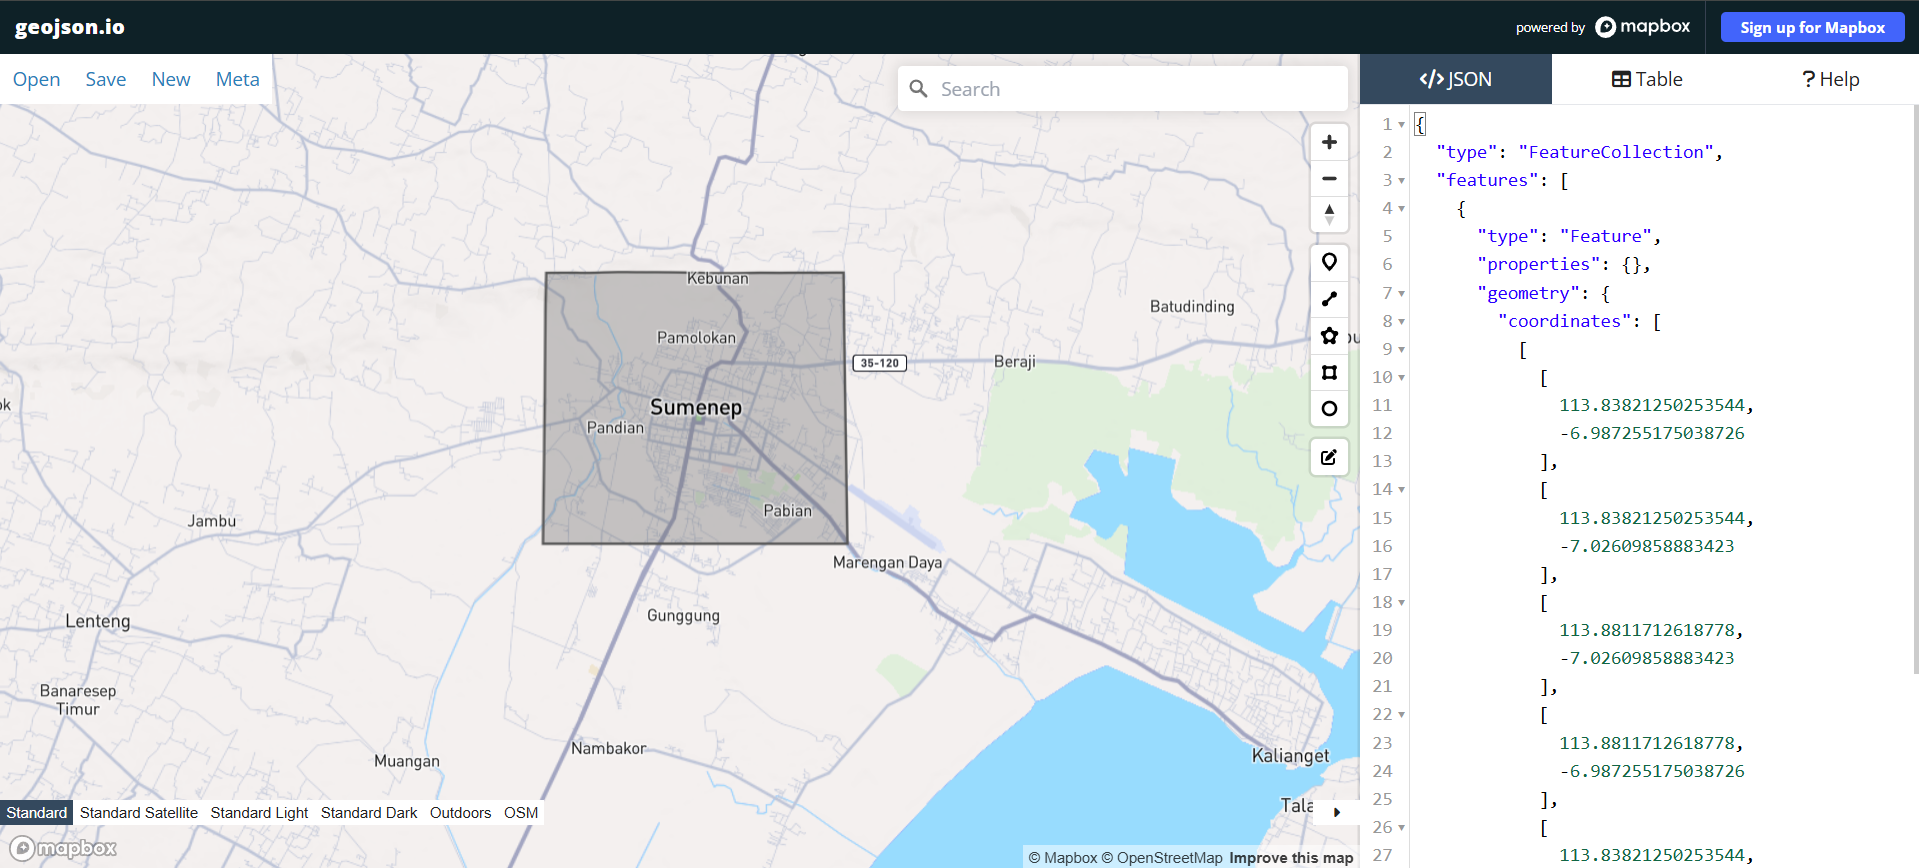

## **Mengambil Data**

Berikut adalah kode yang saya gunakan untuk mengambil data berdasarkan koordinat yang sudah saya dapatkan :

In [ ]:
!pip install openeo

In [1]:
import openeo
from shapely.geometry import shape

In [ ]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

In [ ]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [113.83821250253544, -6.987255175038726],
            [113.83821250253544, -7.02609858883423],
            [113.8811712618778, -7.02609858883423],
            [113.8811712618778, -6.987255175038726],
            [113.83821250253544, -6.987255175038726],
        ]
    ],
}

In [ ]:
prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-09-01", "2025-10-14"],
    spatial_extent={
        "west": 113.83821250253544,
        "south": -7.02609858883423,
        "east": 113.8811712618778,
        "north": -6.987255175038726
    },
    bands=["NO2"],
)

In [ ]:
feature = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [113.83821250253544, -6.987255175038726],
                [113.83821250253544, -7.02609858883423],
                [113.8811712618778, -7.02609858883423],
                [113.8811712618778, -6.987255175038726],
                [113.83821250253544, -6.987255175038726],
            ]
        ],
    },
    "properties": {"id": 1},
}

fc = {
    "type": "FeatureCollection",
    "features": [feature],
}


In [ ]:
# Menggabungkan data berdasarkan periode harian
prob = prob.aggregate_temporal_period(reducer="mean", period="day")

# Melakukan agregasi spasial untuk menghasilkan data deret waktu (timeseries) rata-rata wilayah Sumenep
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)

In [ ]:
job = prob.execute_batch(
    title="NO2 Kabupaten Sumenep Sep–Okt 2025",
    outputfile="no2_sumenep.nc"
)

## **Convert to CSV**

Dataset yang dihasilkan berupa file NetCDF (.nc).

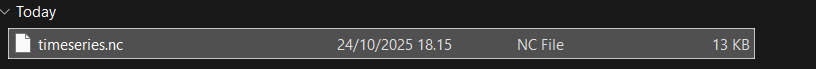

dan akan dikonversi ke format dataset pada umumnya seperti (.csv) untuk mempermudah proses data nantinya.data yang dihasilkan saya beri nama **NO2_Kabupaten_Sumenep.csv**

In [20]:
import xarray as xr

In [25]:
import pandas as pd

# Buka dataset NetCDF
ds = xr.open_dataset("No2_sumenep.nc")

# Lihat struktur untuk memastikan nama variabel dan dimensi
print(ds)

# Ubah dataset menjadi DataFrame
df = ds.to_dataframe().reset_index()

# Cek nama kolom sebelum memilih
print(df.columns)

# Ambil hanya kolom waktu dan NO₂ (ubah sesuai nama aktual)
if 'time' in df.columns:
    df = df[['time', 'NO2']].rename(columns={'time': 't'})
elif 't' in df.columns:
    df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("NO2_Kabupaten_Sumenep.csv", index=False)

print("✅ Data berhasil disimpan sebagai NO2_Kabupaten_Sumenep.csv")


<xarray.Dataset> Size: 584B
Dimensions:        (t: 35, feature: 1)
Coordinates:
  * t              (t) datetime64[ns] 280B 2025-09-01 2025-09-02 ... 2025-10-14
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 280B ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.
Index(['t', 'feature', 'NO2', 'lat', 'lon', 'feature_names'], dtype='object')
✅ Data berhasil disimpan sebagai NO2_Kabupaten_Sumenep.csv


## **Eksplor data**

di tahap ini saya melakukan eksplorasi data untuk mengecek kelayakan dataset setelah di konvert dari (.nc) ke (.csv)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
no2_asli = pd.read_csv('NO2_Kabupaten_Sumenep.csv')
no2_asli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       35 non-null     object 
 1   NO2     35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 692.0+ bytes


In [28]:
# Ubah kolom 'date' menjadi tipe datetime
no2_asli['t'] = pd.to_datetime(no2_asli['t'])
no2_asli.info()

no2 = no2_asli.copy()

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('t')

# Set kolom 'date' sebagai index
no2 = no2.set_index('t')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       35 non-null     datetime64[ns]
 1   NO2     35 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 692.0 bytes
                     NO2
t                       
2025-09-01  7.389449e-06
2025-09-02 -3.703151e-07
2025-09-03 -2.147225e-06
2025-09-04  1.662965e-05
2025-09-05  9.698365e-06


In [29]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end=no2.index.max(), freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2025-09-01', '2025-09-02', '2025-09-03', '2025-09-04',
               '2025-09-05', '2025-09-06', '2025-09-07', '2025-09-08',
               '2025-09-09', '2025-09-10', '2025-09-11', '2025-09-12',
               '2025-09-13', '2025-09-14', '2025-09-15', '2025-09-16',
               '2025-09-17', '2025-09-18', '2025-09-19', '2025-09-20',
               '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24',
               '2025-09-25', '2025-09-26', '2025-09-27', '2025-09-28',
               '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02',
               '2025-10-03', '2025-10-04', '2025-10-05', '2025-10-06',
               '2025-10-07', '2025-10-08', '2025-10-09', '2025-10-10',
               '2025-10-11', '2025-10-12', '2025-10-13', '2025-10-14'],
              dtype='datetime64[ns]', freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2025-09-15', '2025-09-16', '2025-09-17', '2025-09-18',
               '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-11',
      

<div align="justify">

Berdasarkan hasil pengecekan, terdapat missing value pada data, yaitu pada tanggal [ 2025-09-15, 2025-09-16, 2025-09-17, 2025-09-18, 2025-09-29, 2025-09-30, 2025-10-01, 2025-10-11, dan 2025-10-13 ]. Missing value pada tanggal-tanggal tersebut perlu ditangani terlebih dahulu karena dapat memengaruhi akurasi analisis deret waktu (time series) yang akan dilakukan.
<div>

## **Pre-Processing**

<div align='justify'>
Pada tahap ini dilakukan proses awal (preprocessing) untuk menangani tanggal yang hilang (missing dates) yang telah teridentifikasi pada tahap Data Understanding, sekaligus mengubah data deret waktu (time series) menjadi bentuk data supervised.

Data supervised adalah jenis data yang digunakan dalam supervised learning atau pembelajaran terawasi, yaitu metode pembelajaran mesin di mana data memiliki input (fitur) dan output (label) yang sudah diketahui. Tujuan dari metode ini adalah agar model dapat belajar hubungan antara input dan output untuk kemudian memprediksi output baru berdasarkan input yang belum pernah dilihat.
<div>

## **Menangani Missing Value**

<div align="justify">
Untuk menangani nilai yang hilang (missing value) pada data deret waktu, dilakukan proses interpolasi linear. Teknik ini digunakan untuk memperkirakan nilai yang hilang berdasarkan tren linier antara dua titik data terdekat. Dengan metode ini, nilai yang hilang dapat diisi secara proporsional sesuai pola perubahan data sebelumnya dan sesudahnya, sehingga kontinuitas data tetap terjaga dan hasil analisis deret waktu menjadi lebih akurat.

In [30]:
import pandas as pd

# === Baca data ===
no2 = pd.read_csv("NO2_Kabupaten_Sumenep.csv")

# Pastikan kolom tanggal dalam format datetime
no2['t'] = pd.to_datetime(no2['t'], errors='coerce')

# Buang baris yang gagal dikonversi (jika ada)
no2 = no2.dropna(subset=['t'])

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('t')

# Simpan salinan data asli sebelum interpolasi (berguna untuk plot perbandingan nanti)
no2_asli = no2.copy()

# Buat rentang tanggal lengkap sesuai periode data
tanggal_lengkap = pd.date_range(start=no2['t'].min(), end=no2['t'].max(), freq='D')

# Reindex dataframe agar semua tanggal muncul
no2 = no2.set_index('t').reindex(tanggal_lengkap)

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 't' kembali
no2 = no2.reset_index().rename(columns={'index': 't'})

# Cek hasil setelah interpolasi
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

# (Opsional) tampilkan ringkasan
print(f"\nRentang data: {no2['t'].min().date()} s.d. {no2['t'].max().date()}")
print(f"Jumlah total data setelah interpolasi: {len(no2)}")


Jumlah missing value setelah interpolasi:
t      0
NO2    0
dtype: int64

Rentang data: 2025-09-01 s.d. 2025-10-14
Jumlah total data setelah interpolasi: 44


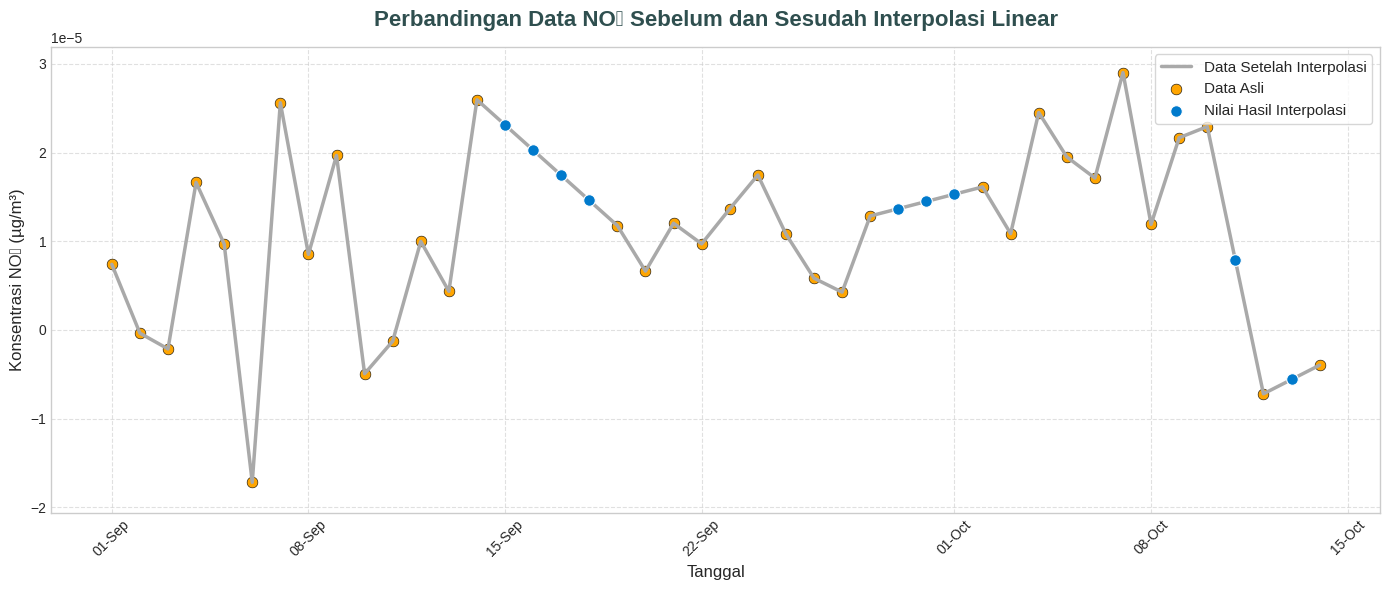

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Pastikan missing_dates dalam format datetime
missing_dates = pd.to_datetime([
    '2025-09-15','2025-09-16','2025-09-17','2025-09-18',
    '2025-09-29','2025-09-30','2025-10-01','2025-10-11','2025-10-13'
])

# Filter data hasil interpolasi yang cocok dengan tanggal tersebut
interpolated_points = no2[no2['t'].isin(missing_dates)]

# Cek jika ada tanggal yang tidak ditemukan agar tidak error
if interpolated_points.empty:
    print("⚠️ Tidak ditemukan data interpolasi pada tanggal yang disebutkan. Pastikan tanggal sesuai rentang data.")
else:
    # Plot
    plt.figure(figsize=(14, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Garis utama (data penuh setelah interpolasi)
    plt.plot(no2['t'], no2['NO2'], color='#A9A9A9', linewidth=2.5, label='Data Setelah Interpolasi')

    # Titik data asli
    plt.scatter(no2_asli['t'], no2_asli['NO2'],
                color='#FFA500', s=60, edgecolor='black', linewidth=0.4,
                label='Data Asli')

    # Titik hasil interpolasi
    plt.scatter(interpolated_points['t'], interpolated_points['NO2'],
                color='#007ACC', s=70, edgecolor='white', linewidth=0.8,
                zorder=5, label='Nilai Hasil Interpolasi')

    # Judul dan label
    plt.title('Perbandingan Data NO₂ Sebelum dan Sesudah Interpolasi Linear',
              fontsize=16, weight='bold', color='#2F4F4F', pad=15)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Konsentrasi NO₂ (µg/m³)', fontsize=12)

    # Format tanggal di sumbu X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Tentukan batas Y secara adaptif
    y_min, y_max = no2['NO2'].min(), no2['NO2'].max()

    # Jika nilai minimum < 0, beri jarak ekstra agar tidak menembus grafik
    if y_min < 0:
        plt.ylim(y_min * 1.2, y_max * 1.1)
    else:
        plt.ylim(y_min * 0.9, y_max * 1.1)

    # Grid dan legenda
    plt.legend(fontsize=11, frameon=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


Data sudah ditangani missing valuenya sehingga bisa dilanjutkan ke proses selanjutnya

## **Ubah Data menjadi Supervised**

<div align="justify">
Pada tahap ini, data deret waktu yang telah lengkap diubah menjadi format data supervised dengan menerapkan teknik sliding window. Prinsipnya, data dari beberapa hari sebelumnya digunakan sebagai variabel input untuk memprediksi nilai pada hari berikutnya. Dalam hal ini, digunakan data dari 10 hari terakhir (t-10 hingga t-1) sebagai masukan untuk memperkirakan nilai hari ke-(t). Pemilihan jendela waktu sebanyak 10 hari dilakukan untuk memberikan konteks historis yang lebih panjang, sehingga diharapkan dapat meningkatkan akurasi prediksi.

In [32]:
supervised = pd.DataFrame()

# Membuat fitur dari 10 hari sebelumnya (lag 10 sampai lag 1)
supervised['t-10'] = no2['NO2'].shift(10)
supervised['t-9'] = no2['NO2'].shift(9)
supervised['t-8'] = no2['NO2'].shift(8)
supervised['t-7'] = no2['NO2'].shift(7)
supervised['t-6'] = no2['NO2'].shift(6)
supervised['t-5'] = no2['NO2'].shift(5)
supervised['t-4'] = no2['NO2'].shift(4)
supervised['t-3'] = no2['NO2'].shift(3)
supervised['t-2'] = no2['NO2'].shift(2)
supervised['t-1'] = no2['NO2'].shift(1)

# Nilai target (hari ke-t)
supervised['t'] = no2['NO2']

# Hapus baris yang memiliki nilai NaN akibat pergeseran
supervised = supervised.dropna().reset_index(drop=True)

supervised.head(10)

t-10           t-9       t-8       t-7       t-6       t-5  \
0  7.389449e-06 -3.703151e-07 -0.000002  0.000017  0.000010 -0.000017   
1 -3.703151e-07 -2.147225e-06  0.000017  0.000010 -0.000017  0.000026   
2 -2.147225e-06  1.662965e-05  0.000010 -0.000017  0.000026  0.000009   
3  1.662965e-05  9.698365e-06 -0.000017  0.000026  0.000009  0.000020   
4  9.698365e-06 -1.719317e-05  0.000026  0.000009  0.000020 -0.000005   
5 -1.719317e-05  2.562031e-05  0.000009  0.000020 -0.000005 -0.000001   
6  2.562031e-05  8.521954e-06  0.000020 -0.000005 -0.000001  0.000010   
7  8.521954e-06  1.966923e-05 -0.000005 -0.000001  0.000010  0.000004   
8  1.966923e-05 -4.947856e-06 -0.000001  0.000010  0.000004  0.000026   
9 -4.947856e-06 -1.274452e-06  0.000010  0.000004  0.000026  0.000023   

        t-4       t-3       t-2       t-1         t  
0  0.000026  0.000009  0.000020 -0.000005 -0.000001  
1  0.000009  0.000020 -0.000005 -0.000001  0.000010  
2  0.000020 -0.000005 -0.000001  0.000010  0.000004  
3 -0.000005 -0.000001  0.000010  0.000004  0.000026  
4 -0.000001  0.000010  0.000004  0.000026  0.000023  
5  0.000010  0.000004  0.000026  0.000023  0.000020  
6  0.000004  0.000026  0.000023  0.000020  0.000017  
7  0.000026  0.000023  0.000020  0.000017  0.000015  
8  0.000023  0.000020  0.000017  0.000015  0.000012  
9  0.000020  0.000017  0.000015  0.000012  0.000007

## **Normalisasi Data**

<div align="justify">
Pada tahap ini, data supervised yang telah terbentuk akan dinormalisasi menggunakan metode MinMaxScaler. Teknik ini berfungsi untuk menskalakan setiap nilai pada fitur agar berada dalam rentang tertentu,umumnya antara 0 hingga 1. Dengan demikian, nilai terkecil dari data asli akan dikonversi menjadi 0, sedangkan nilai terbesarnya akan menjadi 1, sehingga seluruh fitur berada pada skala yang seragam.

In [33]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Normalisasi data supervised dengan rentang 0–1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

# Tampilkan 5 data teratas hasil normalisasi
print("Hasil normalisasi data supervised (rentang 0–1):")
print(scaled.head())

Hasil normalisasi data supervised (rentang 0–1):
       t-10       t-9       t-8       t-7       t-6       t-5       t-4  \
0  0.569683  0.389857  0.348678  0.731823  0.581851  0.000000  0.899808   
1  0.389857  0.348678  0.783818  0.581851  0.000000  0.926354  0.396499   
2  0.348678  0.783818  0.623190  0.000000  0.926354  0.556397  0.724631   
3  0.783818  0.623190  0.000000  0.926354  0.556397  0.797591  0.000000   
4  0.623190  0.000000  0.992169  0.556397  0.797591  0.264951  0.108131   

        t-3       t-2       t-1         t  
0  0.396499  0.741846  0.062514  0.163885  
1  0.724631  0.062514  0.163885  0.474437  
2  0.000000  0.163885  0.474437  0.319073  
3  0.108131  0.474437  0.319073  0.915396  
4  0.439390  0.319073  0.915396  0.837024  


## **Modeling**

<div align='justify'>
Pada tahap ini, model KNN Regressor dari library Scikit-learn akan diterapkan untuk melakukan proses pelatihan (training) dan pengujian (testing) data. Setelah model dijalankan, performanya akan dievaluasi menggunakan dua metrik, yaitu Mean Squared Error (MSE) dan R² Score untuk menilai tingkat akurasi prediksi.

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ✅ Pisahkan fitur (X) dan target (y)
X = scaled.drop(columns=['t'])   # fitur: t-1 sampai t-10
y = scaled['t']                  # target: t (hari ini)

# ✅ Bagi data menjadi training dan testing (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

# ✅ Inisialisasi dan latih model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# ✅ Prediksi pada data testing
y_pred = knn.predict(X_test)

# ✅ Evaluasi performa model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluasi Model KNN:")
print(f"  - Mean Squared Error (MSE): {mse:.4f}")
print(f"  - R² Score: {r2:.4f}")

# ✅ (Opsional) Lihat hasil prediksi
result = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nhasil prediksi:")
print(result.head())


Evaluasi Model KNN:
  - Mean Squared Error (MSE): 0.1244
  - R² Score: -0.0628

hasil prediksi:
     Actual  Predicted
0  0.875590   0.510026
1  0.737332   0.544162
2  0.671656   0.525821
3  1.000000   0.479034
4  0.527529   0.505685


<div align='justify'>
Berdasarkan hasil evaluasi model, diperoleh nilai Mean Squared Error (MSE) sebesar 0.1244 dan R² Score sebesar -0.0628. Nilai R² yang negatif menunjukkan bahwa model KNN Regressor belum mampu menangkap pola hubungan antarhari dengan baik. Meskipun tingkat kesalahannya masih tergolong moderat, akurasi model dapat ditingkatkan dengan melakukan beberapa penyesuaian, seperti menambah jumlah data pelatihan, mengoptimalkan jumlah tetangga (k), atau memperluas jumlah lag sebagai fitur input. Hasil ini menjadi indikasi bahwa model masih perlu disempurnakan agar mampu menghasilkan prediksi yang lebih stabil dan representatif terhadap data NO₂ harian.

In [35]:
# ✅ Buat DataFrame hasil prediksi dan nilai aktual
result = pd.DataFrame({
    'Actual': y_test.values,      # gunakan .values agar index sejajar
    'Predicted': y_pred
}).reset_index(drop=True)

# ✅ Tambahkan kolom error (selisih) agar mudah dianalisis
result['Error'] = result['Predicted'] - result['Actual']

# ✅ Tampilkan ringkasan hasil prediksi
print("\nHasil prediksi KNN Regressor:")
print(result.head())

# ✅ (Opsional) tampilkan ringkasan statistik error
print("\nRingkasan error:")
print(result['Error'].describe().round(4))


Hasil prediksi KNN Regressor:
     Actual  Predicted     Error
0  0.875590   0.510026 -0.365565
1  0.737332   0.544162 -0.193170
2  0.671656   0.525821 -0.145835
3  1.000000   0.479034 -0.520966
4  0.527529   0.505685 -0.021844

Ringkasan error:
count    11.0000
mean     -0.0412
std       0.3674
min      -0.5210
25%      -0.3406
50%      -0.1458
75%       0.2670
max       0.5029
Name: Error, dtype: float64


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# === Baca data ===
no2 = pd.read_csv('NO2_Kabupaten_Sumenep.csv')
no2['t'] = pd.to_datetime(no2['t'])
no2 = no2.sort_values('t')

# === Siapkan fitur waktu numerik ===
no2['day_index'] = np.arange(len(no2))

# === Normalisasi ===
scaler = MinMaxScaler()
no2['NO2_scaled'] = scaler.fit_transform(no2[['NO2']])

X = no2[['day_index']]
y = no2['NO2_scaled']

# === Bagi data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# === Model ===
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# === Evaluasi ===
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluasi Model:")
print(f"  - MSE : {mse:.6f}")
print(f"  - R²  : {r2:.6f}\n")

# === Prediksi otomatis hari berikutnya ===
next_day = no2['t'].iloc[-1] + timedelta(days=1)
next_input = np.array([[no2['day_index'].iloc[-1] + 1]])
next_pred_scaled = knn.predict(next_input)[0]
next_pred = scaler.inverse_transform([[next_pred_scaled]])[0][0]

# === Hasil ===
print(f"Nilai hasil prediksi (skala normalisasi): {next_pred_scaled:.6f}")
print(f"\nPrediksi konsentrasi NO₂ pada {next_day.date()}: {next_pred:.10f} µg/m³")

Evaluasi Model:
  - MSE : 0.063296
  - R²  : -0.143496

Nilai hasil prediksi (skala normalisasi): 0.602460

Prediksi konsentrasi NO₂ pada 2025-10-15: 0.0000106509 µg/m³


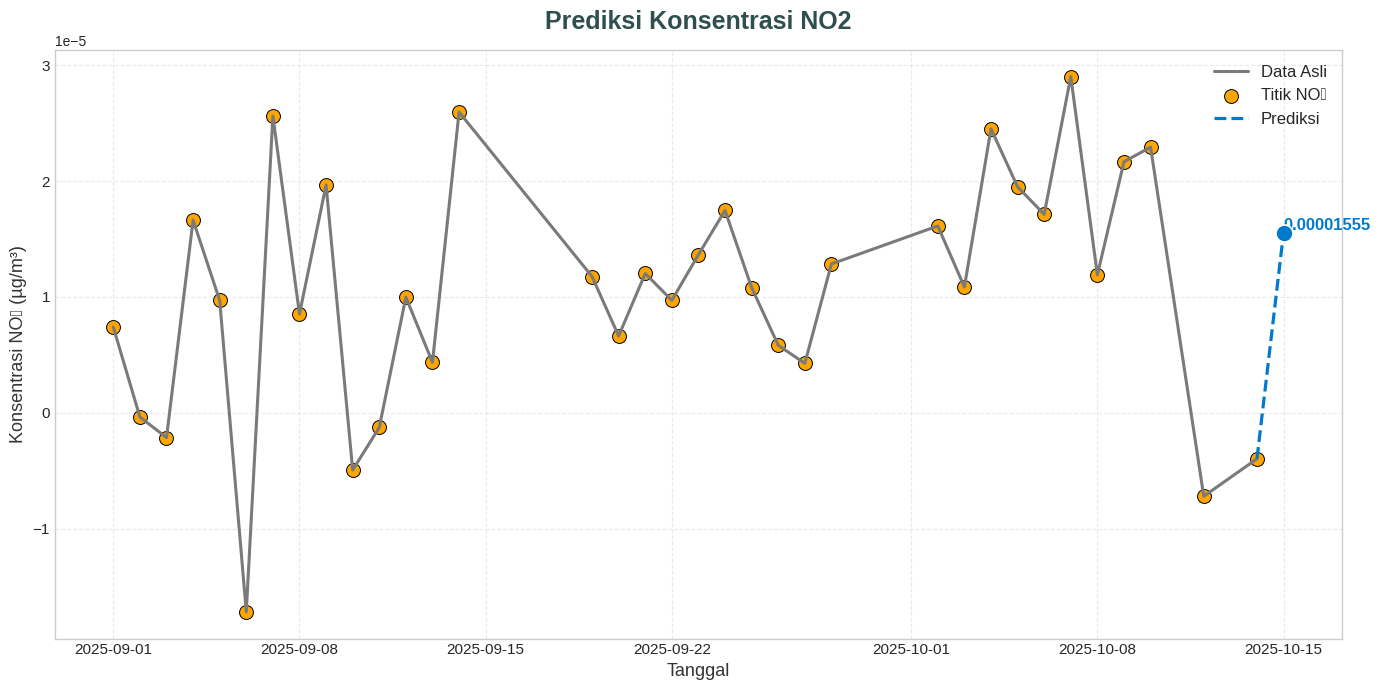

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta

# Baca data
no2 = pd.read_csv('NO2_Kabupaten_Sumenep.csv')

# Ubah kolom tanggal
no2['t'] = pd.to_datetime(no2['t'])
no2 = no2.sort_values('t')

# Normalisasi
scaler = MinMaxScaler()
no2['NO2_scaled'] = scaler.fit_transform(no2[['NO2']])

# Buat fitur waktu (indeks numerik)
no2['day_index'] = np.arange(len(no2))

# Pisahkan fitur dan target
X = no2[['day_index']]
y = no2['NO2_scaled']

# Latih model
model = LinearRegression()
model.fit(X, y)

# Evaluasi model
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Prediksi otomatis hari berikutnya
next_day = no2['t'].iloc[-1] + timedelta(days=1)
next_day_index = np.array([[no2['day_index'].iloc[-1] + 1]])
next_pred_scaled = model.predict(next_day_index)[0]
next_pred = scaler.inverse_transform([[next_pred_scaled]])[0][0]

# === Plot besar ===
plt.figure(figsize=(14, 7))  # Ukuran besar
plt.plot(no2['t'], no2['NO2'], color='#7A7A7A', linestyle='-', linewidth=2.2, label='Data Asli')
plt.scatter(no2['t'], no2['NO2'], color='#FFA500', s=100, edgecolor='black', linewidth=0.7, label='Titik NO₂')

# Garis prediksi
plt.plot([no2['t'].iloc[-1], next_day],
         [no2['NO2'].iloc[-1], next_pred],
         color='#007ACC', linestyle='--', linewidth=2.3, label='Prediksi')

# Titik prediksi
plt.scatter(next_day, next_pred, color='#007ACC', s=150, edgecolor='white', linewidth=1.2, zorder=5)
plt.text(next_day, next_pred, f"{next_pred:.8f}",
         color='#007ACC', fontsize=12, fontweight='bold', ha='left', va='bottom')

# Tampilan umum
plt.title("Prediksi Konsentrasi NO2", color='#2F4F4F', fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Tanggal", color='#333333', fontsize=13)
plt.ylabel("Konsentrasi NO₂ (µg/m³)", color='#333333', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
